In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
import pyarrow as pa
import pyarrow.parquet as pq
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import gc

from model.helper import load_data

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
class MultiColumnLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        output = pd.DataFrame()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(X[col])
        else:
            for colname,col in X.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [4]:
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]

In [5]:
class NanInputter(BaseEstimator, TransformerMixin):
    def __init__(self, nan_value):
        self.nan_value = nan_value

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.fillna(self.nan_value)

In [6]:
class Log(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return np.log10(X).values.reshape(-1,1)

In [7]:
class DayPeriodic(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        hour = pd.to_datetime(X, unit='s').dt.hour
        sin_hour = np.sin(2*np.pi*hour/24)
        cos_hour = np.cos(2*np.pi*hour/24)
        
        return pd.concat([sin_hour, cos_hour], axis=1)

In [8]:
train = pq.read_table('data/train.parquet').to_pandas()
gc.collect()

/home/ivlis/.conda/envs/jlab/lib/python3.7/site-packages/pyarrow/pandas_compat.py:708: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
/home/ivlis/.conda/envs/jlab/lib/python3.7/site-packages/pyarrow/pandas_compat.py:735: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
/home/ivlis/.conda/envs/jlab/lib/python3.7/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


1345

In [9]:
combined_features = FeatureUnion(
    [
        ('AmountLog', make_pipeline(ItemSelector('TransactionAmt'), Log())),
        ('DayPeriodic', make_pipeline(ItemSelector('TransactionDT'), DayPeriodic())),
        ('cat', make_pipeline(
            ItemSelector(['ProductCD', 'card4', 'id_33', 'id_31']), 
            NanInputter('None'),
            MultiColumnLabelEncoder()))
    ])

In [10]:
train_transformed = combined_features.fit_transform(train)

In [5]:
is_fraud_idx = (train.isFraud==1)

In [6]:
train['hour'] = pd.to_datetime(train.TransactionDT, unit='s').dt.hour

In [7]:
gc.collect()

46

The data set is unbanaced, only 4% of transactions are f. 

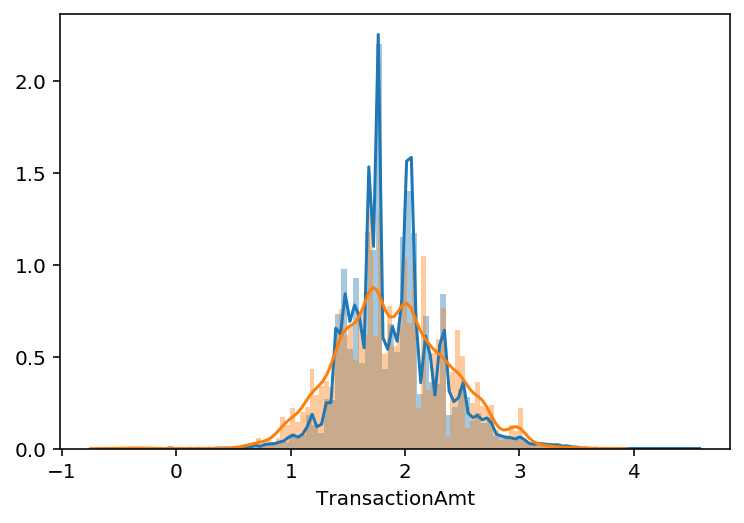

In [51]:
sns.distplot(np.log10(train.TransactionAmt[~is_fraud_idx]), bins=100)
sns.distplot(np.log10(train.TransactionAmt[is_fraud_idx]), bins=100)
# sns.distplot(train.TransactionAmt[~is_fraud_idx])


# plt.xlim(1, 2000)

In [8]:
is_fraud_idx.sum()/(~is_fraud_idx).sum()

0.03625870143908247

Before training our model, we need to filter out potentially insignificat featues.

Since we have two populations ($F$ and $\bar{F}$), we need to find features, which are significantly different in two populations. To do that, we use a dissimilarity index $D_f$. For catigorical featues we define it as follows [https://www.tandfonline.com/doi/abs/10.1080/03610928908830127]:

$$D_f = \dfrac{1}{2}\sum_x 
\left|P_f(F|x) - P_f(\bar{F}|x)\right|,  $$
where $P_f(F|x)$ is the probality of feature $f$ having a value $x$ is the transaction if fraudulet $F$. By definition $0\leqslant D_f \leqslant 1$. Features which have higher dissimilarities should be better predictors for our classifier
